# Physics-Informed Neural Networks (PINNs) for Damped Harmonic Oscillator

## Introduction
This project implements a **Physics-Informed Neural Network (PINN)** to solve the equation of motion for a **damped harmonic oscillator**. PINNs are a class of neural networks that incorporate physical laws, represented by partial differential equations (PDEs), into the training process. Instead of relying solely on labeled data, PINNs leverage the governing equations as a part of the loss function to learn the solution.

The damped harmonic oscillator is governed by the following second-order differential equation:

u_tt + 2 * gamma * u_t + (omega ** 2) * u = 0


where:
-  u(t) : Displacement at time \( t \),
- gamma : Damping coefficient,
- omega : frequency.

This equation describes the motion of a mass-spring-damper system with energy dissipation.

## Goals
1. Solve the differential equation using a PINN without requiring labeled data.
2. Compare the **PINN-predicted solution** with the **analytical solution**.
3. Visualize the predictions and training loss to assess the performance of the PINN.




## Initialising the parameters and actual training points from the solution of differntial equation

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


tf.random.set_seed(42)

# Parameters for the damped harmonic oscillator
gamma = 0.1  # Damping coefficient
omega = 1.0  # frequency
# omega_d = np.sqrt(omega**2 - gamma**2)


# Generating time values for training:
t = np.linspace(0, 10, 200).reshape(-1, 1)  # Time values [0, 10]
t_tf = tf.convert_to_tensor(t, dtype=tf.float32)

# Actual function:
def damp_osci(t):
    return np.exp(-gamma * t) * np.cos(omega * t)


## PINN Model:

In [9]:
# PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        # Simple feedforward neural network
        self.hidden_layer_1 = tf.keras.layers.Dense(50, activation="tanh")
        self.hidden_layer_2 = tf.keras.layers.Dense(50, activation="tanh")
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, t):
        x = self.hidden_layer_1(t)
        x = self.hidden_layer_2(x)
        return self.output_layer(x)    # final predicted displacement u(t)


## Losses:

#### There will be two types of losses:

1. Physics Loss : this will account for the deviation of generated results from our model from the actual differential equation


In [10]:

# Physics-Informed Loss
def physics_loss(model, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        u = model(t)  # Predicted displacement u(t)
        u_t = tape.gradient(u, t)  # First derivative du/dt
    u_tt = tape.gradient(u_t, t)  # Second derivative d^2u/dt^2

    # Differential Equation residual
    residual =  u_tt + 2 * gamma * u_t + (omega ** 2) * u
    return tf.reduce_mean(tf.square(residual))

# Explaination of Physics Loss:
"""
In PINNs, the residual is not the difference between actual and predicted values (as in traditional regression). Instead, it measures how well the predicted output u(t)u(t) satisfies the governing differential equation.

 u_tt + 2 * gamma * u_t + (omega ** 2) * u = 0
This is the differential equation of damped harmonic oscillator

A perfect solution u(t) would make this equation hold true, resulting in a residual of 0 at every time point
"""

'\nIn PINNs, the residual is not the difference between actual and predicted values (as in traditional regression). Instead, it measures how well the predicted output u(t)u(t) satisfies the governing differential equation.\n\n u_tt + 2 * gamma * u_t + (omega ** 2) * u = 0\nThis is the differential equation of damped harmonic oscillator\n\nA perfect solution u(t) would make this equation hold true, resulting in a residual of 0 at every time point\n'

2. Initial Conditions loss: is introduced to make sure the solution predicted by the neural network satisfies the given starting conditions of the problem.

In this case:

At t=0, the displacement u(0) should be 1 .

At t=0, the velocity du/dt should be 0.



In [11]:
# Initial conditions loss:
def initial_conditions_loss(model):
    # Initial condition at t = 0
    t0 = tf.convert_to_tensor([[0.0]], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(t0)
        u0 = model(t0)  # u(0)
    u_t0 = tape.gradient(u0, t0)  # du/dt at t=0

    # Loss terms for u(0) = 1 and du/dt(0) = 0
    ic_loss = tf.square(u0 - 1.0) + tf.square(u_t0 - 0.0)  # u(0) = 1, du/dt(0) = 0
    return ic_loss
# Combined loss
def total_loss(model, t):
    return physics_loss(model, t) + initial_conditions_loss(model)

# Training and Prediction by PINN

In [12]:
# Training the model
@tf.function
def train_step(model, optimizer, t):
    with tf.GradientTape() as tape:
        loss = total_loss(model, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

epochs = 5000
loss_history = []

for epoch in range(epochs):
    loss = train_step(model, optimizer, t_tf)
    loss_history.append(loss.numpy())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

# Predictions
t_test = np.linspace(0, 10, 100).reshape(-1, 1).astype(np.float32)
u_pred = model(t_test)
u_actual = damp_osci(t_test)


Epoch 0: Loss = [[1.0455966]]
Epoch 500: Loss = [[0.02380493]]
Epoch 1000: Loss = [[0.01318613]]
Epoch 1500: Loss = [[0.00966367]]
Epoch 2000: Loss = [[0.00693834]]
Epoch 2500: Loss = [[0.00465111]]
Epoch 3000: Loss = [[0.003449]]
Epoch 3500: Loss = [[0.00278869]]
Epoch 4000: Loss = [[0.00225383]]
Epoch 4500: Loss = [[0.00183722]]


## Visualizations

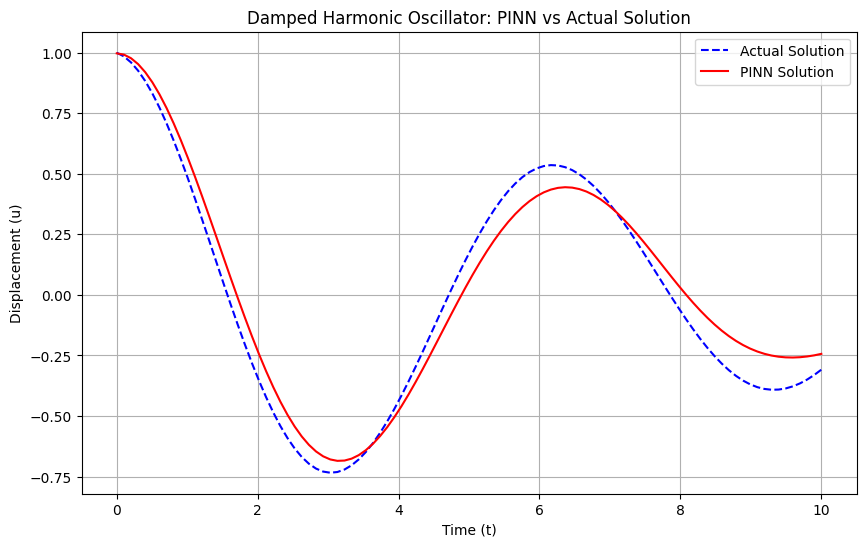

In [14]:

# Plots of time vs displacement
plt.figure(figsize=(10, 6))
plt.plot(t_test, u_actual, label="Actual Solution", color="blue", linestyle="dashed")
plt.plot(t_test,u_pred, label="PINN Solution", color="red")

plt.title("Damped Harmonic Oscillator: PINN vs Actual Solution")
plt.xlabel("Time (t)")
plt.ylabel("Displacement (u)")

plt.legend()
plt.grid()
plt.show()



